# LSTM

## 1. Import libraries 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## 2. Đọc Dataset và chia data thành 2 bộ train và test

In [2]:
# Đọc dữ liệu từ file CSV, lấy các cột cần thiết và phân tích cột 'Date' làm chỉ mục
df = pd.read_csv('gld_price_data.csv', index_col='Date', parse_dates=True, usecols=['Date','GLD', 'USO', 'SLV','EUR/USD'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(inplace=True)

# Loại bỏ các dòng có giá trị thiếu (NaN) trong dữ liệu
df = df.dropna()

# Tách dữ liệu thành train_data và test_data theo tỉ lệ 80:20
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

# In kích thước của tập dữ liệu huấn luyện
print('Shape of data train', train_data.shape)

# In kích thước của tập dữ liệu kiểm tra
print('Shape of data test', test_data.shape)

# Tách biến mục tiêu 'GLD' từ tập dữ liệu huấn luyện
y_train = train_data['GLD']
y_test = test_data['GLD']

# Tách các biến đầu vào (features) từ tập dữ liệu huấn luyện, loại bỏ cột 'GLD'
X_train = train_data.drop(columns=['GLD'])
X_test = test_data.drop(columns=['GLD'])

Shape of data train (1832, 5)
Shape of data test (458, 5)


## 3. Dataset overview

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2290 non-null   datetime64[ns]
 1   GLD      2290 non-null   float64       
 2   USO      2290 non-null   float64       
 3   SLV      2290 non-null   float64       
 4   EUR/USD  2290 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 89.6 KB


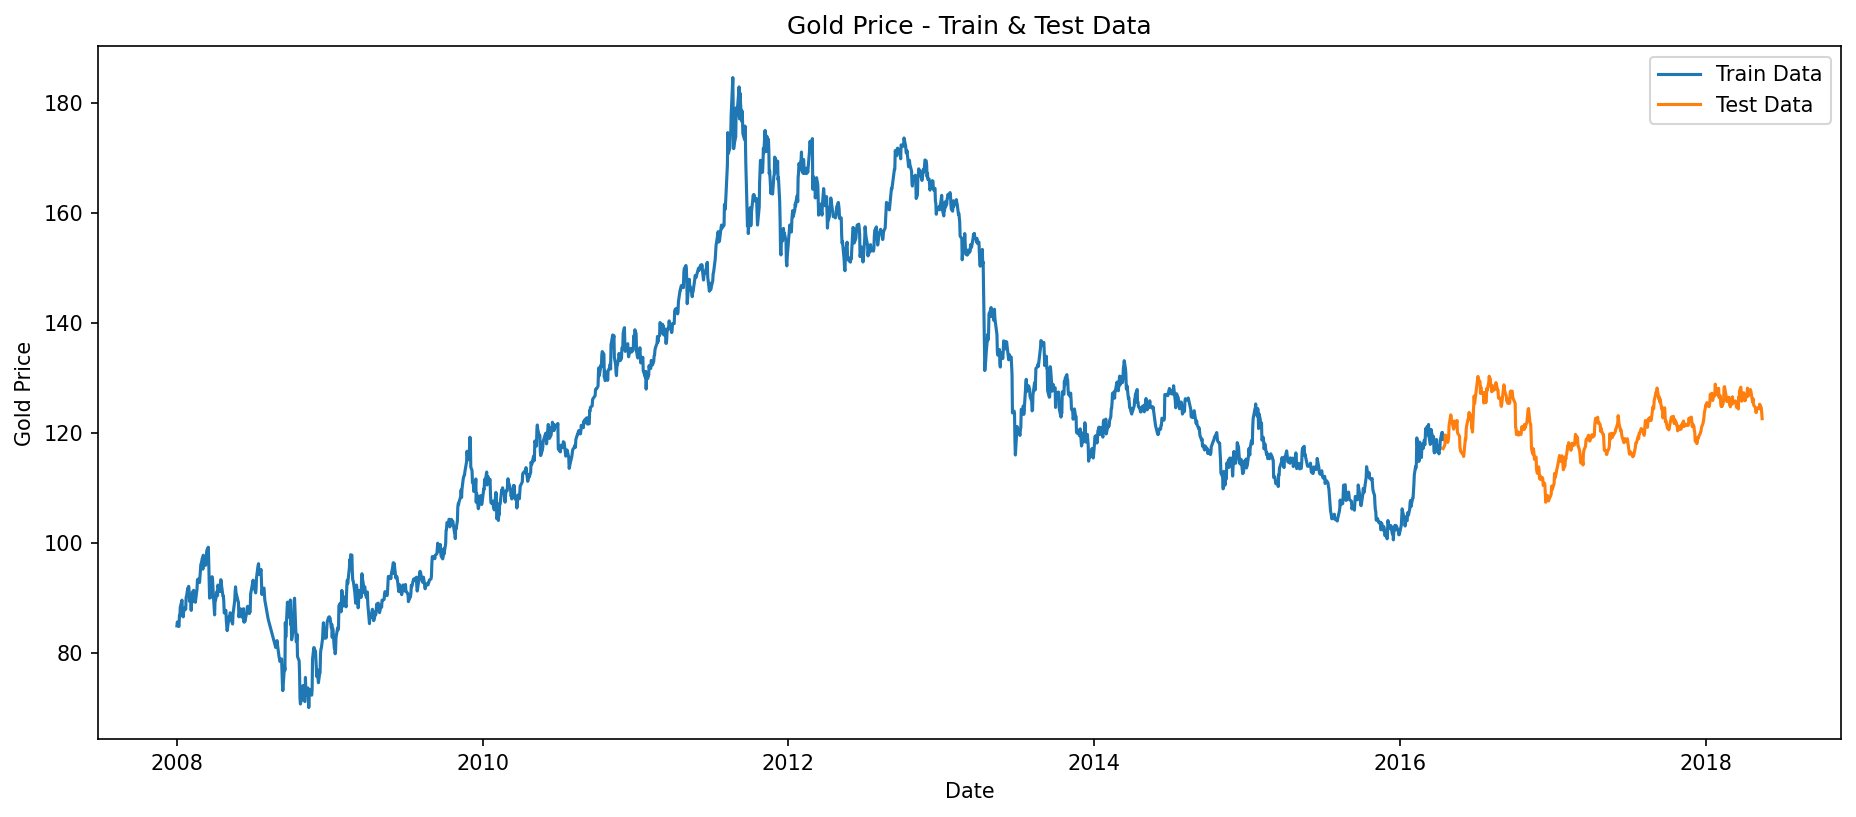

In [4]:
# Thiết lập kích thước biểu đồ với chiều rộng full (ví dụ 15 inch)
plt.figure(figsize=(15, 6), dpi=150)

# Vẽ biểu đồ cho tập huấn luyện (train)
plt.plot(train_data['Date'], y_train, label='Train Data')

# Vẽ biểu đồ cho tập kiểm tra (test)
plt.plot(test_data['Date'], y_test, label='Test Data')

# Thêm tiêu đề và nhãn
plt.title('Gold Price - Train & Test Data')
plt.xlabel('Date')
plt.ylabel('Gold Price')

# Chú thích
plt.legend()

# Hiển thị biểu đồ
plt.grid(color='white')
plt.show()

## 4. Thông tin chi tiết của tập Train và Test

In [5]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1832 entries, 0 to 1831
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     1832 non-null   datetime64[ns]
 1   GLD      1832 non-null   float64       
 2   USO      1832 non-null   float64       
 3   SLV      1832 non-null   float64       
 4   EUR/USD  1832 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 85.9 KB
<class 'pandas.core.frame.DataFrame'>
Index: 458 entries, 1832 to 2289
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     458 non-null    datetime64[ns]
 1   GLD      458 non-null    float64       
 2   USO      458 non-null    float64       
 3   SLV      458 non-null    float64       
 4   EUR/USD  458 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 21.5 KB


## 5. Khởi tạo và huấn luyện mô hình LSTM

In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [7]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['GLD']])

In [8]:
# Tạo hàm chia dữ liệu thành chuỗi
def create_sequences(data, target_index, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length, target_index])
    return np.array(sequences), np.array(labels)

In [9]:
# Thiết lập tham số
sequence_length = 10
target_index = df.columns.get_loc('GLD') - 1  # Vị trí cột 'GLD' trong scaled_data
train_scaled = scaled_data[:len(train_data)]
test_scaled = scaled_data[len(train_data):]

In [10]:
# Tạo tập train và test
X_train, y_train = create_sequences(train_scaled, target_index, sequence_length)
X_test, y_test = create_sequences(test_scaled, target_index, sequence_length)


In [11]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\ASUS\anaconda3\envs\THDataMining\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0754 - val_loss: 5.4623e-04
Epoch 2/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 4.4260e-04
Epoch 3/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.3921e-04 - val_loss: 4.2246e-04
Epoch 4/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - val_loss: 4.1794e-04
Epoch 5/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.3455e-04 - val_loss: 4.2329e-04
Epoch 6/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9252e-04 - val_loss: 4.1836e-04
Epoch 7/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7551e-04 - val_loss: 4.9152e-04
Epoch 8/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2971e-04 - val_loss: 4.8422e-04
Epoch 9/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0736e-04 - val_loss: 4.2557e-04
Epoch 10/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7521e-04 - val_loss: 3.9233e-04
Epoch 11/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9503e-04 - val_los

In [13]:
# Dự đoán trên tập test
predictions = model.predict(X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


In [14]:
# Tạo cột giả với các giá trị 0 có kích thước phù hợp với predictions
dummy_features = np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))

# Nối cột dự đoán vào cột giả
predictions_rescaled = scaler.inverse_transform(
    np.hstack([dummy_features, predictions])
)[:, -1]

# Tương tự cho y_test
dummy_features_test = np.zeros((y_test.shape[0], scaled_data.shape[1] - 1))

y_test_rescaled = scaler.inverse_transform(
    np.hstack([dummy_features_test, y_test.reshape(-1, 1)])
)[:, -1]



In [15]:
# Tính toán các chỉ số
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
mape = mean_absolute_percentage_error(y_test_rescaled, predictions_rescaled) * 100
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"MAE: {mae}")


RMSE: 1.1684252895724618
MAPE: 0.7410938434986392%
MAE: 0.9007167986782333


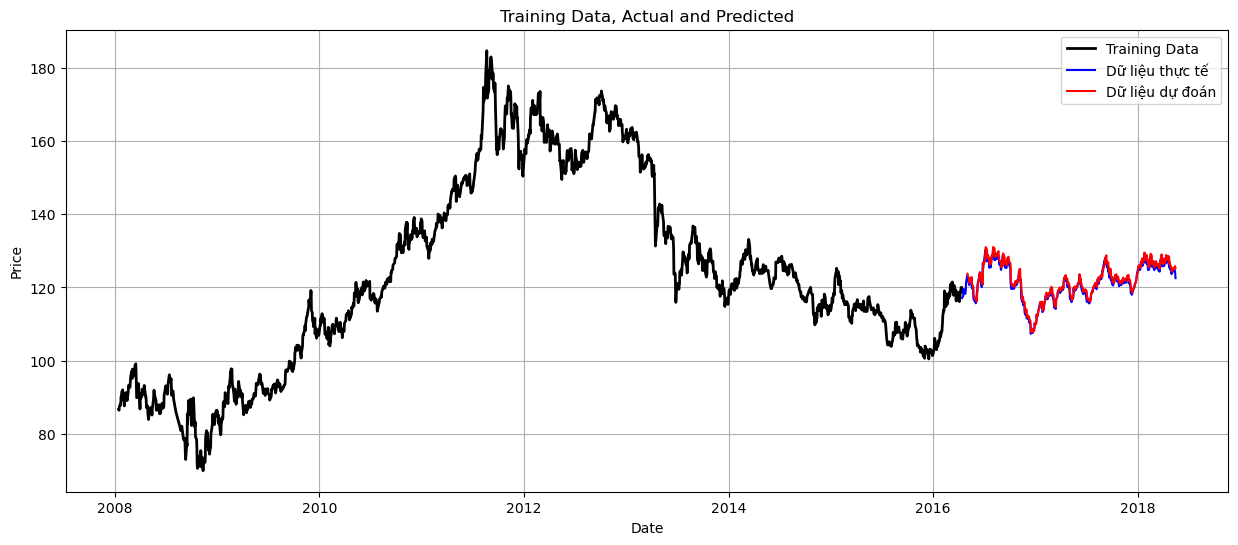

In [16]:

plt.figure(figsize=(15, 6))

# Nếu dữ liệu đã được chuẩn hóa, cần chuyển ngược lại về giá trị gốc
y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1))
# Sau đó vẽ lại dữ liệu huấn luyện
plt.plot(train_data['Date'][sequence_length:], y_train_rescaled, color='black', lw=2, label='Training Data')

# Vẽ dữ liệu thực tế (test set)
plt.plot(test_data['Date'], test_data['GLD'], label='Dữ liệu thực tế', color='blue')

# Vẽ dữ liệu dự đoán (dùng sequence_length để căn chỉnh)
plt.plot(test_data['Date'][sequence_length:], predictions_rescaled, label='Dữ liệu dự đoán', color='red')

# Thêm tiêu đề và nhãn
plt.title('Training Data, Actual and Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

# Hiển thị legend
plt.legend()

# Hiển thị biểu đồ
plt.show()


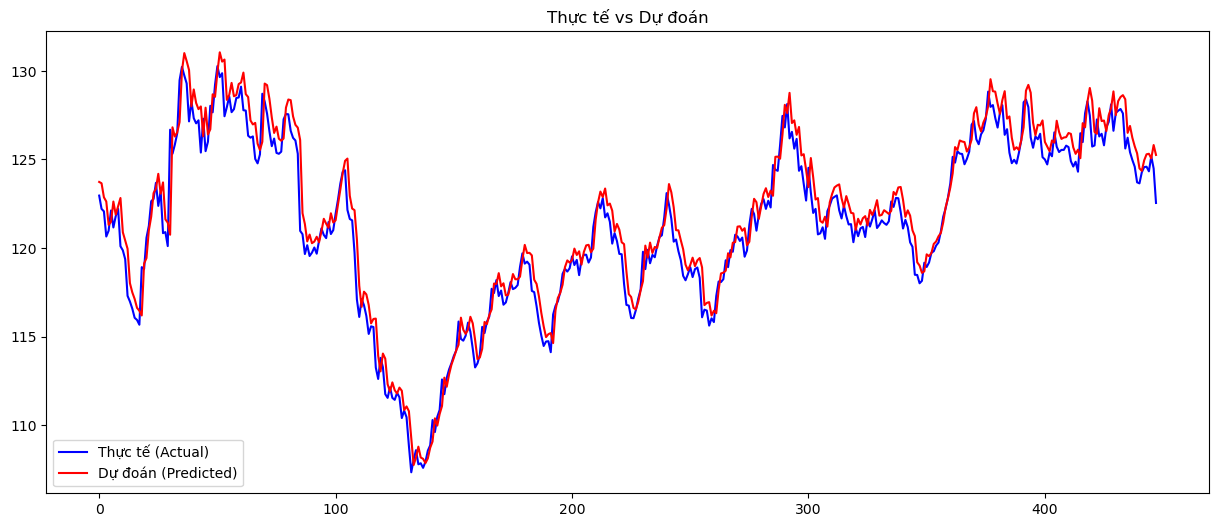

In [17]:
plt.figure(figsize=(15, 6))
plt.plot(y_test_rescaled, label='Thực tế (Actual)', color='blue')
plt.plot(predictions_rescaled, label='Dự đoán (Predicted)', color='red')
plt.legend()
plt.title('Thực tế vs Dự đoán')
plt.show()


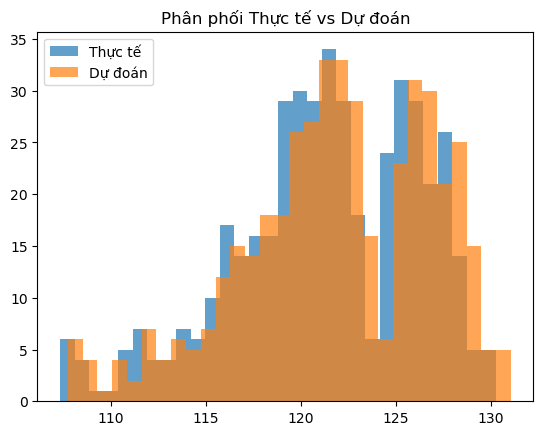

In [18]:
plt.hist(y_test_rescaled, bins=30, alpha=0.7, label='Thực tế')
plt.hist(predictions_rescaled, bins=30, alpha=0.7, label='Dự đoán')
plt.legend()
plt.title('Phân phối Thực tế vs Dự đoán')
plt.show()
